In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='25-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
INPUT_PT_PATH = f"/workspace/datasets/profiles-v2/profiles-v2-pca-5d/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca-5d/profiles_v2_experiment_25-5d_20250803_0107


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca-5d/profiles_v2_experiment_25-5d_20250803_0107/density_plot.png


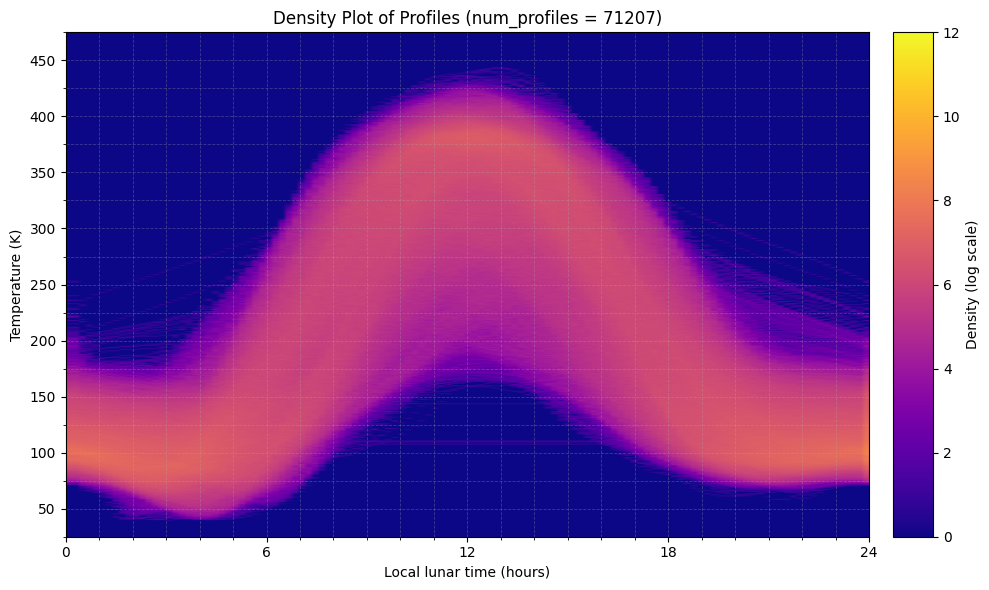

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.9675
STD: 97.2997
Min Temp: 40.0240
Max Temp: 443.4440
Datasets:
Training Data: 49844
Validation Data: 14241
Test Data: 7122


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 250/250 [00:08<00:00, 30.12it/s, best_loss=0.8582]


[Training] Epoch 1/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0055, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 72/72 [00:00<00:00, 104.51it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0002
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca-5d/profiles_v2_experiment_25-5d_20250803_0107'


[Training] Epoch 2/100: 100%|██████████| 250/250 [00:08<00:00, 29.75it/s, best_loss=0.8758]


[Training] Epoch 2/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0002, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 72/72 [00:00<00:00, 107.95it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 3/100: 100%|██████████| 250/250 [00:08<00:00, 29.95it/s, best_loss=0.8973]


[Training] Epoch 3/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 72/72 [00:00<00:00, 105.01it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 4/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.8780]


[Training] Epoch 4/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 72/72 [00:00<00:00, 107.15it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 5/100: 100%|██████████| 250/250 [00:08<00:00, 30.53it/s, best_loss=0.8748]


[Training] Epoch 5/100, L1 Loss: 0.8193, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 72/72 [00:00<00:00, 106.30it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 6/100: 100%|██████████| 250/250 [00:08<00:00, 30.81it/s, best_loss=0.8810]


[Training] Epoch 6/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 72/72 [00:00<00:00, 105.99it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 7/100: 100%|██████████| 250/250 [00:08<00:00, 30.49it/s, best_loss=0.8634]


[Training] Epoch 7/100, L1 Loss: 0.8193, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 72/72 [00:00<00:00, 105.97it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 8/100: 100%|██████████| 250/250 [00:08<00:00, 30.12it/s, best_loss=0.8519]


[Training] Epoch 8/100, L1 Loss: 0.8197, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 72/72 [00:00<00:00, 105.54it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 9/100: 100%|██████████| 250/250 [00:08<00:00, 30.12it/s, best_loss=0.8788]


[Training] Epoch 9/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 72/72 [00:00<00:00, 106.46it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 10/100: 100%|██████████| 250/250 [00:08<00:00, 30.45it/s, best_loss=0.8735]


[Training] Epoch 10/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 72/72 [00:00<00:00, 107.91it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 11/100: 100%|██████████| 250/250 [00:08<00:00, 30.42it/s, best_loss=0.8797]


[Training] Epoch 11/100, L1 Loss: 0.8193, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 72/72 [00:00<00:00, 106.13it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 12/100: 100%|██████████| 250/250 [00:08<00:00, 30.06it/s, best_loss=0.9097]


[Training] Epoch 12/100, L1 Loss: 0.8195, L2 Loss: 1.0006, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 72/72 [00:00<00:00, 107.02it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 13/100: 100%|██████████| 250/250 [00:08<00:00, 29.82it/s, best_loss=0.8529]


[Training] Epoch 13/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 72/72 [00:00<00:00, 103.11it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 14/100: 100%|██████████| 250/250 [00:08<00:00, 28.60it/s, best_loss=0.8819]


[Training] Epoch 14/100, L1 Loss: 0.8196, L2 Loss: 1.0005, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 72/72 [00:00<00:00, 99.07it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 15/100: 100%|██████████| 250/250 [00:08<00:00, 30.69it/s, best_loss=0.8950]


[Training] Epoch 15/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 72/72 [00:00<00:00, 105.28it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 16/100: 100%|██████████| 250/250 [00:08<00:00, 30.36it/s, best_loss=0.8982]


[Training] Epoch 16/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 72/72 [00:00<00:00, 108.44it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 17/100: 100%|██████████| 250/250 [00:08<00:00, 30.46it/s, best_loss=0.9042]


[Training] Epoch 17/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 72/72 [00:00<00:00, 108.68it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 18/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.8913]


[Training] Epoch 18/100, L1 Loss: 0.8196, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 72/72 [00:00<00:00, 107.23it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 19/100: 100%|██████████| 250/250 [00:08<00:00, 30.84it/s, best_loss=0.8635]


[Training] Epoch 19/100, L1 Loss: 0.8193, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 72/72 [00:00<00:00, 109.83it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 20/100: 100%|██████████| 250/250 [00:08<00:00, 30.12it/s, best_loss=0.8896]


[Training] Epoch 20/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 72/72 [00:00<00:00, 106.09it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 21/100: 100%|██████████| 250/250 [00:08<00:00, 30.75it/s, best_loss=0.9024]


[Training] Epoch 21/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 72/72 [00:00<00:00, 106.91it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 22/100: 100%|██████████| 250/250 [00:08<00:00, 30.70it/s, best_loss=0.8887]


[Training] Epoch 22/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 72/72 [00:00<00:00, 107.13it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 23/100: 100%|██████████| 250/250 [00:08<00:00, 29.76it/s, best_loss=0.8961]


[Training] Epoch 23/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 72/72 [00:00<00:00, 104.90it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 24/100: 100%|██████████| 250/250 [00:08<00:00, 29.76it/s, best_loss=0.8902]


[Training] Epoch 24/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 72/72 [00:00<00:00, 103.55it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 25/100: 100%|██████████| 250/250 [00:08<00:00, 30.36it/s, best_loss=0.8801]


[Training] Epoch 25/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 72/72 [00:00<00:00, 106.60it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 26/100: 100%|██████████| 250/250 [00:08<00:00, 30.70it/s, best_loss=0.8873]


[Training] Epoch 26/100, L1 Loss: 0.8194, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 72/72 [00:00<00:00, 102.57it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 27/100: 100%|██████████| 250/250 [00:08<00:00, 30.56it/s, best_loss=0.9045]


[Training] Epoch 27/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 72/72 [00:00<00:00, 108.95it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 28/100: 100%|██████████| 250/250 [00:08<00:00, 30.39it/s, best_loss=0.9085]


[Training] Epoch 28/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 72/72 [00:00<00:00, 106.85it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 29/100: 100%|██████████| 250/250 [00:08<00:00, 30.33it/s, best_loss=0.8941]


[Training] Epoch 29/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 72/72 [00:00<00:00, 105.77it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 30/100: 100%|██████████| 250/250 [00:08<00:00, 29.45it/s, best_loss=0.8679]


[Training] Epoch 30/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 72/72 [00:00<00:00, 102.77it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 31/100: 100%|██████████| 250/250 [00:08<00:00, 29.73it/s, best_loss=0.8828]


[Training] Epoch 31/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 72/72 [00:00<00:00, 105.13it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 32/100: 100%|██████████| 250/250 [00:08<00:00, 30.02it/s, best_loss=0.8520]


[Training] Epoch 32/100, L1 Loss: 0.8192, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 72/72 [00:00<00:00, 103.29it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 33/100: 100%|██████████| 250/250 [00:08<00:00, 30.30it/s, best_loss=0.9145]


[Training] Epoch 33/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 72/72 [00:00<00:00, 106.52it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 34/100: 100%|██████████| 250/250 [00:08<00:00, 30.43it/s, best_loss=0.8943]


[Training] Epoch 34/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 72/72 [00:00<00:00, 105.55it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 35/100: 100%|██████████| 250/250 [00:08<00:00, 30.42it/s, best_loss=0.8889]


[Training] Epoch 35/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 72/72 [00:00<00:00, 107.70it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 36/100: 100%|██████████| 250/250 [00:08<00:00, 30.27it/s, best_loss=0.8847]


[Training] Epoch 36/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 72/72 [00:00<00:00, 107.70it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 37/100: 100%|██████████| 250/250 [00:08<00:00, 29.96it/s, best_loss=0.8909]


[Training] Epoch 37/100, L1 Loss: 0.8196, L2 Loss: 1.0005, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 72/72 [00:00<00:00, 109.54it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 38/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.8995]


[Training] Epoch 38/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 72/72 [00:00<00:00, 104.61it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 39/100: 100%|██████████| 250/250 [00:08<00:00, 30.82it/s, best_loss=0.8823]


[Training] Epoch 39/100, L1 Loss: 0.8196, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 72/72 [00:00<00:00, 102.45it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 40/100: 100%|██████████| 250/250 [00:08<00:00, 30.58it/s, best_loss=0.8777]


[Training] Epoch 40/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 72/72 [00:00<00:00, 104.93it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 41/100: 100%|██████████| 250/250 [00:08<00:00, 30.41it/s, best_loss=0.9040]


[Training] Epoch 41/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 72/72 [00:00<00:00, 107.29it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 42/100: 100%|██████████| 250/250 [00:08<00:00, 30.30it/s, best_loss=0.8598]


[Training] Epoch 42/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 72/72 [00:00<00:00, 102.26it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 43/100: 100%|██████████| 250/250 [00:08<00:00, 30.75it/s, best_loss=0.8791]


[Training] Epoch 43/100, L1 Loss: 0.8193, L2 Loss: 0.9996, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 72/72 [00:00<00:00, 106.17it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 44/100: 100%|██████████| 250/250 [00:08<00:00, 29.37it/s, best_loss=0.9009]


[Training] Epoch 44/100, L1 Loss: 0.8194, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 72/72 [00:00<00:00, 101.33it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 45/100: 100%|██████████| 250/250 [00:08<00:00, 30.13it/s, best_loss=0.8973]


[Training] Epoch 45/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 72/72 [00:00<00:00, 106.38it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 46/100: 100%|██████████| 250/250 [00:08<00:00, 30.03it/s, best_loss=0.9060]


[Training] Epoch 46/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 72/72 [00:00<00:00, 104.81it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 47/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.9054]


[Training] Epoch 47/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 72/72 [00:00<00:00, 108.19it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 48/100: 100%|██████████| 250/250 [00:08<00:00, 29.63it/s, best_loss=0.8307]


[Training] Epoch 48/100, L1 Loss: 0.8192, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 72/72 [00:00<00:00, 108.76it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 49/100: 100%|██████████| 250/250 [00:08<00:00, 30.41it/s, best_loss=0.8886]


[Training] Epoch 49/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 72/72 [00:00<00:00, 115.07it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 50/100: 100%|██████████| 250/250 [00:08<00:00, 30.29it/s, best_loss=0.9030]


[Training] Epoch 50/100, L1 Loss: 0.8194, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 72/72 [00:00<00:00, 103.86it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 51/100: 100%|██████████| 250/250 [00:08<00:00, 29.28it/s, best_loss=0.8308]


[Training] Epoch 51/100, L1 Loss: 0.8192, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 72/72 [00:00<00:00, 99.35it/s] 


[Validation] Epoch 51/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 52/100: 100%|██████████| 250/250 [00:08<00:00, 30.32it/s, best_loss=0.8783]


[Training] Epoch 52/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 72/72 [00:00<00:00, 113.35it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 53/100: 100%|██████████| 250/250 [00:08<00:00, 30.84it/s, best_loss=0.8869]


[Training] Epoch 53/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 72/72 [00:00<00:00, 111.72it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 54/100: 100%|██████████| 250/250 [00:08<00:00, 30.59it/s, best_loss=0.9052]


[Training] Epoch 54/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 72/72 [00:00<00:00, 112.33it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 55/100: 100%|██████████| 250/250 [00:08<00:00, 30.71it/s, best_loss=0.8749]


[Training] Epoch 55/100, L1 Loss: 0.8193, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 72/72 [00:00<00:00, 105.11it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 56/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.8793]


[Training] Epoch 56/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 72/72 [00:00<00:00, 108.71it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 57/100: 100%|██████████| 250/250 [00:08<00:00, 30.44it/s, best_loss=0.8792]


[Training] Epoch 57/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 72/72 [00:00<00:00, 106.26it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 58/100: 100%|██████████| 250/250 [00:08<00:00, 30.06it/s, best_loss=0.8668]


[Training] Epoch 58/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 72/72 [00:00<00:00, 105.75it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 59/100: 100%|██████████| 250/250 [00:08<00:00, 30.36it/s, best_loss=0.8944]


[Training] Epoch 59/100, L1 Loss: 0.8194, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 72/72 [00:00<00:00, 105.46it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 60/100: 100%|██████████| 250/250 [00:08<00:00, 29.92it/s, best_loss=0.8155]


[Training] Epoch 60/100, L1 Loss: 0.8192, L2 Loss: 0.9994, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 72/72 [00:00<00:00, 99.05it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 61/100: 100%|██████████| 250/250 [00:08<00:00, 29.86it/s, best_loss=0.8818]


[Training] Epoch 61/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 72/72 [00:00<00:00, 105.17it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 62/100: 100%|██████████| 250/250 [00:08<00:00, 30.21it/s, best_loss=0.8815]


[Training] Epoch 62/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 72/72 [00:00<00:00, 110.16it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 63/100: 100%|██████████| 250/250 [00:08<00:00, 30.35it/s, best_loss=0.8947]


[Training] Epoch 63/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 72/72 [00:00<00:00, 111.55it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 64/100: 100%|██████████| 250/250 [00:08<00:00, 29.59it/s, best_loss=0.9047]


[Training] Epoch 64/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 72/72 [00:00<00:00, 90.74it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 65/100: 100%|██████████| 250/250 [00:08<00:00, 29.69it/s, best_loss=0.8895]


[Training] Epoch 65/100, L1 Loss: 0.8194, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 72/72 [00:00<00:00, 108.09it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 66/100: 100%|██████████| 250/250 [00:08<00:00, 30.79it/s, best_loss=0.8641]


[Training] Epoch 66/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 72/72 [00:00<00:00, 105.16it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 67/100: 100%|██████████| 250/250 [00:08<00:00, 30.27it/s, best_loss=0.8798]


[Training] Epoch 67/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 72/72 [00:00<00:00, 105.69it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 68/100: 100%|██████████| 250/250 [00:08<00:00, 30.47it/s, best_loss=0.8742]


[Training] Epoch 68/100, L1 Loss: 0.8195, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 72/72 [00:00<00:00, 97.04it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 69/100: 100%|██████████| 250/250 [00:08<00:00, 30.79it/s, best_loss=0.8829]


[Training] Epoch 69/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 72/72 [00:00<00:00, 109.78it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 70/100: 100%|██████████| 250/250 [00:08<00:00, 30.23it/s, best_loss=0.8962]


[Training] Epoch 70/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 72/72 [00:00<00:00, 104.65it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 71/100: 100%|██████████| 250/250 [00:08<00:00, 29.07it/s, best_loss=0.8927]


[Training] Epoch 71/100, L1 Loss: 0.8195, L2 Loss: 1.0003, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 72/72 [00:00<00:00, 103.56it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 72/100: 100%|██████████| 250/250 [00:08<00:00, 29.04it/s, best_loss=0.8607]


[Training] Epoch 72/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 72/72 [00:00<00:00, 95.61it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 73/100: 100%|██████████| 250/250 [00:08<00:00, 30.06it/s, best_loss=0.9050]


[Training] Epoch 73/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 72/72 [00:00<00:00, 106.86it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 74/100: 100%|██████████| 250/250 [00:08<00:00, 29.63it/s, best_loss=0.8784]


[Training] Epoch 74/100, L1 Loss: 0.8194, L2 Loss: 1.0002, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 72/72 [00:00<00:00, 107.66it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 75/100: 100%|██████████| 250/250 [00:08<00:00, 30.02it/s, best_loss=0.8949]


[Training] Epoch 75/100, L1 Loss: 0.8196, L2 Loss: 1.0003, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 72/72 [00:00<00:00, 105.46it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 76/100: 100%|██████████| 250/250 [00:08<00:00, 29.77it/s, best_loss=0.8989]


[Training] Epoch 76/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 72/72 [00:00<00:00, 91.70it/s] 


[Validation] Epoch 76/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 77/100: 100%|██████████| 250/250 [00:08<00:00, 30.64it/s, best_loss=0.8817]


[Training] Epoch 77/100, L1 Loss: 0.8194, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 72/72 [00:00<00:00, 108.62it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 78/100: 100%|██████████| 250/250 [00:08<00:00, 30.66it/s, best_loss=0.8449]


[Training] Epoch 78/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 72/72 [00:00<00:00, 97.60it/s] 


[Validation] Epoch 78/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 79/100: 100%|██████████| 250/250 [00:08<00:00, 30.66it/s, best_loss=0.8860]


[Training] Epoch 79/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 72/72 [00:00<00:00, 104.41it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 80/100: 100%|██████████| 250/250 [00:08<00:00, 30.01it/s, best_loss=0.9023]


[Training] Epoch 80/100, L1 Loss: 0.8196, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 72/72 [00:00<00:00, 105.78it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 81/100: 100%|██████████| 250/250 [00:08<00:00, 29.52it/s, best_loss=0.8760]


[Training] Epoch 81/100, L1 Loss: 0.8193, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 72/72 [00:00<00:00, 107.35it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 82/100: 100%|██████████| 250/250 [00:08<00:00, 30.40it/s, best_loss=0.9125]


[Training] Epoch 82/100, L1 Loss: 0.8193, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 72/72 [00:00<00:00, 104.73it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 83/100: 100%|██████████| 250/250 [00:08<00:00, 30.88it/s, best_loss=0.8885]


[Training] Epoch 83/100, L1 Loss: 0.8196, L2 Loss: 1.0003, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 72/72 [00:00<00:00, 103.01it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 84/100: 100%|██████████| 250/250 [00:08<00:00, 30.79it/s, best_loss=0.8877]


[Training] Epoch 84/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 72/72 [00:00<00:00, 108.29it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 85/100: 100%|██████████| 250/250 [00:08<00:00, 29.54it/s, best_loss=0.8795]


[Training] Epoch 85/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 72/72 [00:00<00:00, 103.00it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 86/100: 100%|██████████| 250/250 [00:08<00:00, 29.80it/s, best_loss=0.8718]


[Training] Epoch 86/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 72/72 [00:00<00:00, 108.23it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 87/100: 100%|██████████| 250/250 [00:08<00:00, 29.78it/s, best_loss=0.8019]


[Training] Epoch 87/100, L1 Loss: 0.8192, L2 Loss: 0.9994, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 72/72 [00:00<00:00, 101.13it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 88/100: 100%|██████████| 250/250 [00:08<00:00, 29.47it/s, best_loss=0.9069]


[Training] Epoch 88/100, L1 Loss: 0.8195, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 72/72 [00:00<00:00, 105.58it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 89/100: 100%|██████████| 250/250 [00:08<00:00, 29.82it/s, best_loss=0.9065]


[Training] Epoch 89/100, L1 Loss: 0.8193, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 72/72 [00:00<00:00, 103.06it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 90/100: 100%|██████████| 250/250 [00:08<00:00, 30.45it/s, best_loss=0.8828]


[Training] Epoch 90/100, L1 Loss: 0.8194, L2 Loss: 0.9997, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 72/72 [00:00<00:00, 100.96it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 91/100: 100%|██████████| 250/250 [00:08<00:00, 30.15it/s, best_loss=0.9062]


[Training] Epoch 91/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 72/72 [00:00<00:00, 105.35it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 92/100: 100%|██████████| 250/250 [00:08<00:00, 29.55it/s, best_loss=0.9078]


[Training] Epoch 92/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 72/72 [00:00<00:00, 102.89it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 93/100: 100%|██████████| 250/250 [00:08<00:00, 29.47it/s, best_loss=0.8869]


[Training] Epoch 93/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 72/72 [00:00<00:00, 99.06it/s] 


[Validation] Epoch 93/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 94/100: 100%|██████████| 250/250 [00:08<00:00, 29.86it/s, best_loss=0.8861]


[Training] Epoch 94/100, L1 Loss: 0.8196, L2 Loss: 1.0004, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 72/72 [00:00<00:00, 105.68it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 95/100: 100%|██████████| 250/250 [00:08<00:00, 30.08it/s, best_loss=0.8965]


[Training] Epoch 95/100, L1 Loss: 0.8194, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 72/72 [00:00<00:00, 108.40it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 96/100: 100%|██████████| 250/250 [00:08<00:00, 30.03it/s, best_loss=0.9051]


[Training] Epoch 96/100, L1 Loss: 0.8194, L2 Loss: 0.9998, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 72/72 [00:00<00:00, 105.80it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 97/100: 100%|██████████| 250/250 [00:08<00:00, 29.56it/s, best_loss=0.8986]


[Training] Epoch 97/100, L1 Loss: 0.8194, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 72/72 [00:00<00:00, 102.92it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 98/100: 100%|██████████| 250/250 [00:08<00:00, 29.67it/s, best_loss=0.8827]


[Training] Epoch 98/100, L1 Loss: 0.8195, L2 Loss: 1.0001, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 72/72 [00:00<00:00, 103.96it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 99/100: 100%|██████████| 250/250 [00:08<00:00, 29.06it/s, best_loss=0.8267]


[Training] Epoch 99/100, L1 Loss: 0.8192, L2 Loss: 0.9995, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 72/72 [00:00<00:00, 104.70it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


[Training] Epoch 100/100: 100%|██████████| 250/250 [00:08<00:00, 29.95it/s, best_loss=0.8705]


[Training] Epoch 100/100, L1 Loss: 0.8197, L2 Loss: 1.0005, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 72/72 [00:00<00:00, 101.60it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.8174, Val L2 Loss: 0.9971, Val KL Loss: 0.0001


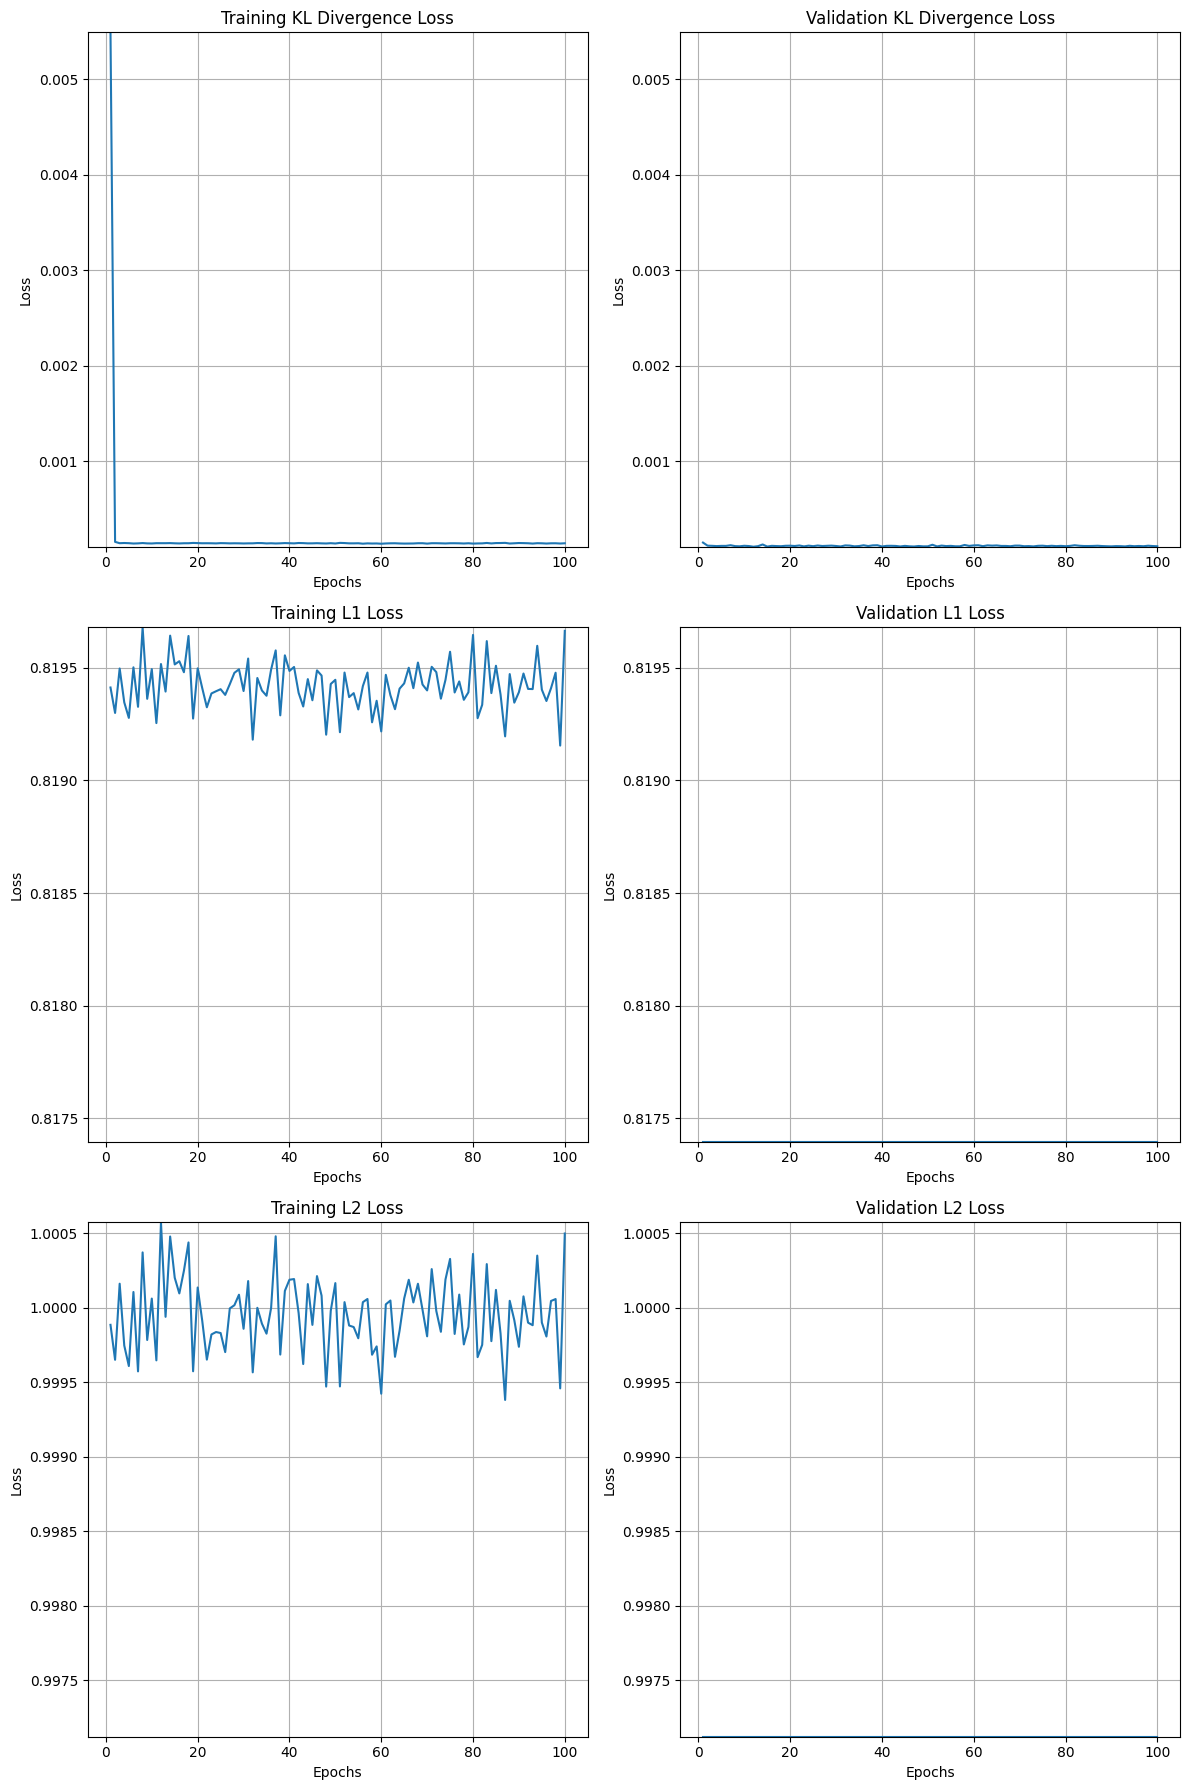

Best Validation Loss in Kelvins:
79.5325 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


z0: 0.0021
z1: 0.0006
z2: -0.0009
z3: -0.0007


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 647.70it/s]


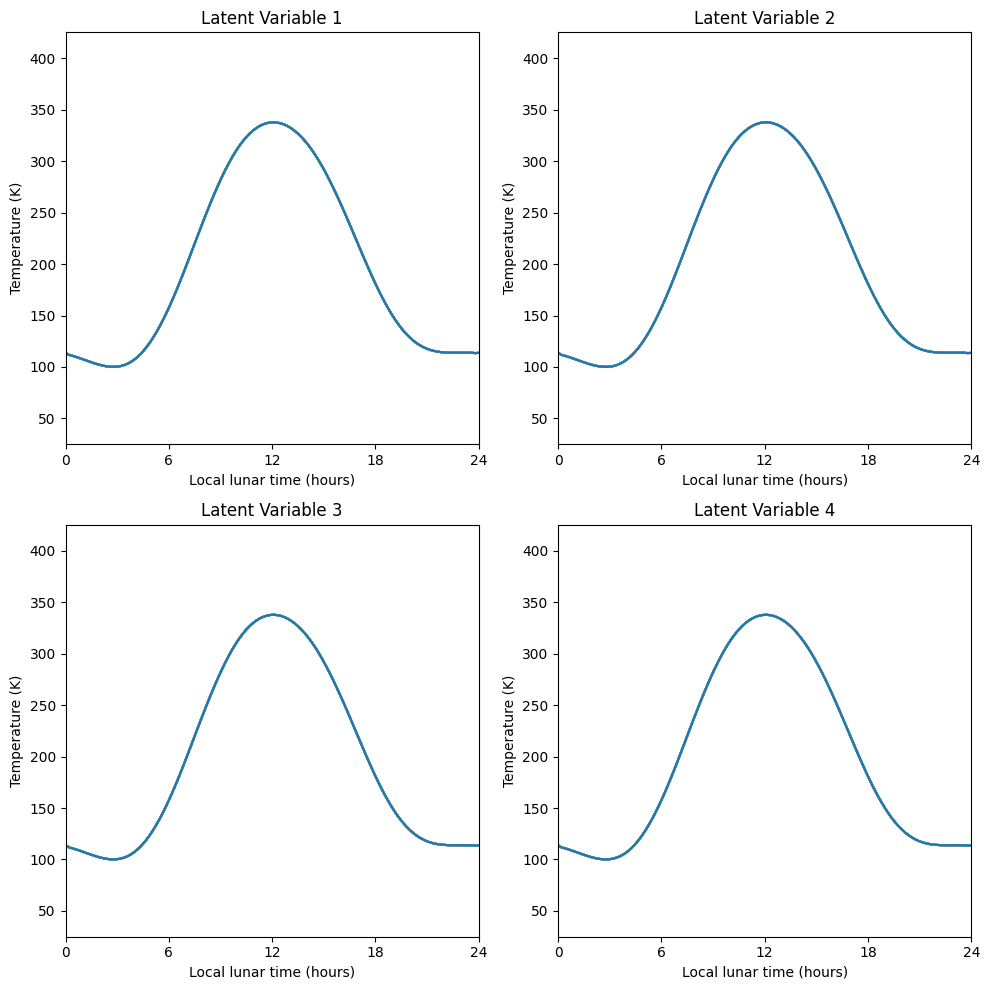

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)